#### Advanced Lane Finding Project
##### The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients k1 k2 and k3--> using chessboard images.
* Now undistor the images to get the real world dimensions.
* Use the advantages of color space HLS and Sobel operator. Combine the best of both to figure out the lane lines andcreate a thresholded binary image.
* Execute a perspective transform ont hte binary images to get a ("birds-eye view") and make the remeining steps like detect lane line and fit a 2d polynomial easier.
* Detect pixels of the lane line with slipping window method
* Fit a polynomial to calculate the curvature of the lane and to get vehicle position with respect to center.
* Transform the detected lane lines from the warped image (bird eye view) back into a unwarped undistorted imageack into the
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



In [ ]:
#  Initialize the enviraonment conditions for etect lane lines
import numpy as np                 # NumPy
import cv2                         # openCV
import glob                        # Filename pattern matching
import matplotlib.pyplot as plt    # 2D plotting
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import pickle
import os
from scipy.stats.stats import pearsonr
from skimage import color


left_fitx_old = None
right_fitx_old = None
leftx_base_old = None
rightx_base_old = None

detected = False
leftx_old = None
lefty_old = None
rightx_old = None
righty_old = None

left_fit_old = None
right_fit_old = None

# path for output examples of the several steps
image_path = 'output_images/chessboard_corners/'
image_path_undistorted_images = 'output_images/'

# path from test images
img_dir = 'test_images/'
images = os.listdir(img_dir)

# Interactive plotting in separate window
#%matplotlib qt
# Visualizations will be shown in the notebook
%matplotlib inline

### Helper function

In [23]:
# define pickle to save the distoriton coefficients k1,k1 and k3 'dist' and the camera matrix as 'mtx'
def pickle_dump(mtx, dist):
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open('wide_dist_pickle.p', 'wb'))
    
def pickle_load():
    # Getting back the camera calibration result:
    with open('wide_dist_pickle.p', 'rb') as f:
        dist_pickle = pickle.load(f)
        return dist_pickle['mtx'], dist_pickle['dist']
    
def draw_and_save_image(path, name, plot=False,save= False):
    # Draw the plot
    if plot:
        plt.imshow(img)
        plt.show()
    # Save to the file
    if save:
        write_name = name + '.jpg'
        cv2.imwrite(str(path) + write_name,img)
    return

# For universal plotting of results
def plot_row2(img1, img2, label_1, label_2, graysc=True):
    # Plot the result (1 row with 2 images)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    f.tight_layout()
    if graysc:
        ax1.imshow(img1, cmap='gray')
    else:
        ax1.imshow(img1)
    ax1.set_title(label_1, fontsize=16)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(label_2, fontsize=16)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
            

### Execute the Camera calibration with the calibration images

In [ ]:
#Calculate the 3d and 2d points for preparing the camera calibration
def find2D3DCorners():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    print('Num of calibration images: {0}'.format(len(images)))
    print('Watching the images in the:',path)
    
    # Step through the list and search for chessboard corners
    for img_id, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            # draw and save depending on given arguments and pathes
            draw_and_save_image(image_path, 'chesboard_corners'+ str(img_id),plot=True,save=True)
            
    return objpoints, imgpoints

In [ ]:
# Calibrate the camero using the find2D3DCorners and cv2.calibrateCamera
# returns the mtx=camera matrix for tranfer 3d into 2d,dis=distortion coefficients
# In this project we will ignore the rvecs=rotation Vectors, tvecs=translationVectors
# This step have to be done only once in the project for getting mtx and dist of the calibration images
def calibrate_camera(img):
    img_size = (img.shape[1], img.shape[0])
    # Claculate the 2d and 3d object point 
    objpoints, imgpoints = find2D3DCorners()
    # Calculate the camera matrix dist=distortion coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # Save the camera ntx and dist to pickle data set
    pickle_dump(mtx, dist)
    print('CALIBRATION DONE')
    return mtx, dist

# execute calibration step
mtx, dist = calibrate_camera(img)


### Color Threshold and Gradient Threshold

#### Gradient Threshold Methods with

In [ ]:
# Apply Sobel directional gradient and apply gradient threshold
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Take s-channel of HLS color space
    img_trans = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_trans = img_trans[:,:,2]
    # Calculate the derivative. That depends on argument orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img_trans, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(img_trans, cv2.CV_64F, 0, 1, ksize=sobel_kernel) 
    # Calc absolute gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros_like(scaled_sobel)
    # is > thresh_min and < thresh_max
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return mask as binary_output image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to HLS
    img_trans = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Take the s channel as reference
    img_trans = img_trans[:,:,2]
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(img_trans, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img_trans, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return masked image as the binary_output image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to HLS and take S channel
    img_trans = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_trans = img_trans[:,:,2]
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(img_trans, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img_trans, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # Use np.arctan2(abs_sobel_y, abs_sobimg_transel_x) to calculate the direction of the gradient
    absgraddir = np.arctan2(abs_sobel_y, abs_sobel_x)
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return this mask as binary_output image
    return binary_output

In [ ]:
def combinedGradientThresholds(img, do_plot=False):
    # Gaussian Blur
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    # Sobel kernel size (choose a larger odd number to smooth gradient measurements)
    ksize = 7
    # Apply Sobel on x-axis
    grad_x_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 255))
    # Apply Sobel on y-axis
    grad_y_binary = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(65, 255))
    # Apply Sobel x and y, compute the magnitude of the gradient and apply a threshold
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(65, 255))
    # Apply Sobel x and y, computes the direction of the gradient and apply a threshold
    #dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))
    #dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.1, 1.0))    
    
    
    #f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(grad_x_binary,cmap='gray')
    #ax1.set_title('grad_x_binary', fontsize=50)
    #ax2.imshow(grad_y_binary,cmap='gray')
    #ax2.set_title('grad_y_binary', fontsize=50)
    #ax3.imshow(mag_binary,cmap='gray')
    #ax3.set_title('mag_binary', fontsize=50)
    ##ax4.imshow(dir_binary,cmap='gray')
    ##ax4.set_title('dir_binary', fontsize=50)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    # Combine the thresholds
    combined = np.zeros_like(grad_x_binary)
    combined[((grad_x_binary == 1)&(mag_binary ==1)&(grad_y_binary == 1)) | ((grad_x_binary == 1) & (mag_binary ==1))| (grad_x_binary == 1) ] = 1
    
    # Return the best of Gradient Threshold
    return combined

#### Color Threshold Methods

In [ ]:
# combine the best out of two worös color and gradient threshold methods
def combinedColorSpaceThresholds(img, thresh=(0, 255)):
    
    # Convert to HLS color space and separate the S channel
    #hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    # Color Space B from LAB
    lab = color.rgb2lab(img)
    b_channel = lab[:,:,2] 
    b_thresh_min = 25
    b_thresh_max = 255
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    # Color Space B from LAB
    luv = color.rgb2luv(img)
    l_channel = luv[:,:,0] 
    l_thresh_min = 85
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    
        
    return l_binary, b_binary, s_binary

#### Combine Color Threshold and Gradient Threshold

In [ ]:
def combineColorAndGradientThresholds(image):
    # Perform Sobel operations and combine thresholds
    combinedGradientSobel = combinedGradientThresholds(image)
    #plot_row2(image, combinedGradientSobel, 'undistorted' ,'Sobel Combined Gradients', graysc=True)
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(image)
    #ax1.set_title('image', fontsize=50)
    #ax2.imshow(combinedGradientSobel,cmap='gray')
    #ax2.set_title('combinedGradientSobel', fontsize=50)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    #
    # Threshold color channel
    #combinedColorThresholds = combinedColorSpaceThresholds(image, thresh=(160, 255))
    l_binary, b_binary, s_binary = combinedColorSpaceThresholds(image, thresh=(180, 255))
    #plot_row2(image, combinedColorThresholds, 'undistorted' ,'Color Threshold', graysc=True)
    combined_binary = np.zeros_like(s_binary)
    combined_binary[((s_binary == 1) & (b_binary == 1))|((l_binary == 1)&(s_binary == 1))|((l_binary == 1)|(b_binary == 1))] = 1
    #f, (ax1, ax2,ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(l_binary,cmap='gray')
    #ax1.set_title('l_binary', fontsize=50)
    #ax2.imshow(s_binary,cmap='gray')
    #ax2.set_title('s_binary', fontsize=50)
    #ax3.imshow(b_binary,cmap='gray')
    #ax3.set_title('b_binary', fontsize=50)
    #ax4.imshow(combined_binary,cmap='gray')
    #ax4.set_title('combined_binary', fontsize=50)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    # Combine color and gradient thresholds
    combinedThresholdsBinaryImage = np.zeros_like(combinedGradientSobel)
    #combinedThresholdsBinaryImage[(combinedGradientSobel == 1) | (combinedColorThresholds == 1)] = 1
    #combinedThresholdsBinaryImage[((combinedGradientSobel == 1) | (l_binary == 1))&((combinedGradientSobel == 1) | (s_binary == 1))&((combinedGradientSobel == 1) | (b_binary == 1))] = 1
    combinedThresholdsBinaryImage[(combined_binary==1) | (combinedGradientSobel == 1)]=1
    #plot_row2(image, combinedThresholdsBinaryImage, 'undistorted' ,'Color and Sobel Combined Threshold', graysc=True)

    
    
    return combinedThresholdsBinaryImage

In [ ]:
# Practical approach to define src and dst point in the original and output image
def calcSrcAndDstPoints(img):
    
    #Define 4 source points
    src = np.float32([[180, img.shape[0]], [575, 460], 
                      [705, 460], [1150, img.shape[0]]])
    # Define 4 destination points
    dst = np.float32([[320, img.shape[0]], [320, 0], 
                      [960, 0], [960, img.shape[0]]])
    
    
    return src,dst

In [ ]:
# Implement Sliding Windows and Fit a Polynomial
def slidingWindowMethod (binary_warped, leftx_base, rightx_base):
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    
    
    
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #left_fit, right_fit = polynomFit2nd(lefty, leftx, righty, rightx)
    #left_fitx, right_fitx, ploty = genrateValuesXYforPlot(binary_warped,left_fit,right_fit)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(binary_warped)
    #ax1.set_title('binary_warped', fontsize=50)
    #ax2.imshow(out_img)
    #ax2.set_title('out_img', fontsize=50)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
           
    

    
    
    #return out_img,ploty,leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx,
    return out_img,leftx, lefty, rightx, righty

In [ ]:
def polynomFit2nd(lefty, leftx, righty, rightx):
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    return left_fit, right_fit

In [ ]:
def genrateValuesXYforPlot(binary_warped,left_fit,right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx,right_fitx,ploty

In [ ]:
# Applies an image mask
# Only keeps the region of the image defined by the polygon formed from `vertices`.
# The rest of the image is set to black.
def region_of_interest(img, vertices):
    # Defining a blank mask to start with
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    # Fill pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    # Return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [ ]:
def sanityCheck(left_fitx,right_fitx,threshold=0.85):
    global left_fitx_old
    global right_fitx_old
    global detected
    
    if (left_fitx_old == None):
        left_fitx_old = left_fitx
                
    if (right_fitx_old == None):
        right_fitx_old = right_fitx
        
   
    ret_left = pearsonr(left_fitx_old, left_fitx)
    ret_right = pearsonr(right_fitx_old, right_fitx)
    
    if (ret_left[0] > threshold):
        left_fitx_old = left_fitx
        detected = True
    else:
        left_fitx = left_fitx_old
        detected = False
    
    if (ret_right[0] > threshold):
        right_fitx_old = right_fitx
        detected = True
    else:
        right_fitx = right_fitx_old
        detected = False
        
    return left_fitx, right_fitx, detected

In [ ]:
  
def main(img):
    # Load calibration data generated in calibrate_camera
    mtx, dist = pickle_load()
    # Calculate the undistorted image
    image_undistored = cv2.undistort(img, mtx, dist, None, mtx)
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(img)
    #ax1.set_title('Original Image', fontsize=50)
    #ax2.imshow(image_undistored)
    #ax2.set_title('Undistorted Image', fontsize=50)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    #Calculate combined binaryImage based on a mix of both
    # combinedColorThresholds and combinedSobelGradient threshold methods
    combinedThresholdsBinaryImage = combineColorAndGradientThresholds(image_undistored)    # define source_img and destination_img point for preparing the perspective transform
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(image_undistored)
    #ax1.set_title('image_undistored', fontsize=50)
    #ax2.imshow(combinedThresholdsBinaryImage, cmap ='gray')
    #ax2.set_title('combinedThresholdsBinaryImage', fontsize=50)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    # using cv2.findChessboardCorners
    src, dst = calcSrcAndDstPoints(combinedThresholdsBinaryImage)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    img_size = (combinedThresholdsBinaryImage.shape[1], combinedThresholdsBinaryImage.shape[0])
    binary_warped = cv2.warpPerspective(combinedThresholdsBinaryImage, M, img_size, flags=cv2.INTER_LINEAR)    
    
   
    
    
    # Define image mask (polygon of interest)
    binaryWarpedImageShape = binary_warped.shape
    vertices = np.array([[(200, binaryWarpedImageShape[0]), (200, 0), (binaryWarpedImageShape[1] - 200, 0), 
                      (binaryWarpedImageShape[1]-200, binaryWarpedImageShape[0])]], dtype=np.int32)
    binaryWarpedMaskedImage = region_of_interest(binary_warped, vertices)
    
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(binary_warped, cmap ='gray')
    #ax1.set_title('binary_warped', fontsize=50)
    #ax2.imshow(binaryWarpedMaskedImage, cmap ='gray')
    #ax2.set_title('binaryWarpedMaskedImage', fontsize=50)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
   
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    mid_of_lane = leftx_base + (rightx_base - leftx_base) / 2
    car_pos = binary_warped.shape[1] / 2
    deviation = int(abs(mid_of_lane - car_pos) * (3.7 / 700) * 100)  

    global detected
    global leftx_base_old
    global rightx_base_old
    global left_fit_old 
    global right_fit_old
    global leftx_old
    global lefty_old
    global rightx_old
    global righty_old
    #print("before", abs(leftx_base - rightx_base))
    
    if (leftx_base_old == None):
        leftx_base_old = leftx_base
        
    if (rightx_base_old == None):
        rightx_base_old = rightx_base
    if (abs(leftx_base - rightx_base) < 250) & (abs(leftx_base - rightx_base) > 160):
        leftx_base_old = leftx_base
        rightx_base_old = rightx_base
    else:
        leftx_base = leftx_base_old
        rightx_base = rightx_base_old
    print('this is the state before choosing window method',detected)

    #if (detected == False):
    #    out_img,leftx, lefty, rightx, righty = slidingWindowMethod(binaryWarpedMaskedImage,leftx_base, rightx_base)
    #    if (len(leftx) < 1500):
    #        leftx = leftx_old 
    #        lefty = lefty_old
    #        detected == False
    #    else:
    #        leftx_old = leftx
    #        lefty_old = lefty
#
    #    if (len(rightx) < 1500):
    #        rightx = rightx_old
    #        righty = righty_old
    #        detected == False
    #    else:
    #        rightx_old = rightx
    #        righty_old = righty
    #        
#
    #    left_fit, right_fit = polynomFit2nd(lefty, leftx, righty, rightx)
    #    left_fit_old = left_fit
    #    right_fit_old = right_fit
    #    
    #if (detected == True):    
    #    out_img,leftx, lefty, rightx, righty = lookAheadFilter(left_fit_old, right_fit_old, binaryWarpedMaskedImage)
    #    if (len(leftx) < 1500):
    #        leftx = leftx_old 
    #        lefty = lefty_old
    #        detected == False
    #    else:
    #        leftx_old = leftx
    #        lefty_old = lefty
#
    #    if (len(rightx) < 1500):
    #        rightx = rightx_old
    #        righty = righty_old
    #        detected == False
    #    else:
    #        rightx_old = rightx
    #        righty_old = righty
    #        
    #    left_fit, right_fit = polynomFit2nd(lefty, leftx, righty, rightx)
    #    left_fit_old = left_fit
    #    right_fit_old = right_fit        
    #
    out_img,leftx, lefty, rightx, righty = slidingWindowMethod(binaryWarpedMaskedImage,leftx_base, rightx_base)
    left_fit, right_fit = polynomFit2nd(lefty, leftx, righty, rightx)
    left_fitx, right_fitx, ploty = genrateValuesXYforPlot(binaryWarpedMaskedImage,left_fit,right_fit)
    print('this is the state after generate XY values',detected)

    #left_fitx, right_fitx, detected = sanityCheck(left_fitx, right_fitx)
    
    
    
    print('this is the state',detected)
    
   

    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(binaryWarpedMaskedImage, cmap ='gray')
    #ax1.set_title('binary_warped', fontsize=50)
    #ax2.imshow(out_img,cmap ='gray')
    #ax2.set_title('out_img', fontsize=50)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    #       
    
    
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    left_curveradMeter, right_curveradMeter = convertRadiusIntoMeter(ploty,y_eval,leftx, lefty, rightx, righty)
    
    #Compute the inverse perspective transform to unwarped the image
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    finalOutputImage = drawPolynomialsBackIntoOriginalImage(binaryWarpedMaskedImage,image_undistored, out_img, left_fitx, right_fitx, left_curveradMeter, right_curveradMeter,deviation, ploty, Minv)
    
    return finalOutputImage
    

In [ ]:
# LOOK AHEAD FILTER
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def lookAheadFilter(left_fit,right_fit,binary_warped):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255    

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
   
    
    return out_img,leftx,lefty,rightx,righty

In [ ]:
#Test Image Pipeline
for image in images:
    print(img_dir + image)
    img = mpimg.imread(img_dir + image)
    result = main(img)
    plt.imshow(result)
    #plt.imsave(image + "_found.png", result)
    plt.show()
    


In [ ]:
# MONITOR (FOR TESTING IMAGE PIPELINE)
image = mpimg.imread('test_images/test5.jpg')
result = main(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('image', fontsize=50)
ax2.imshow(result)
ax2.set_title('result', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.imshow(result)
#plt.imsave(image + "_found.png", result)
#plt.show()

In [ ]:
#left_line = Line()
#right_line = Line()
detected = False
#output_video = 'first_diffcult_section.mp4'
output_video = 'submission_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(22,28)
video_clip = clip1.fl_image(main)
%time video_clip.write_videofile(output_video, audio=False)

#white_output = 'first_draft.mp4'
#clip1 = VideoFileClip("project_video.mp4")
#white_clip = clip1.fl_image(main) #NOTE: this function expects color images!!
#time white_clip.write_videofile(white_output, audio=False)

In [ ]:
# Calculate the radius in real world space with the following formula:

def convertRadiusIntoMeter(ploty,y_eval,leftx, lefty, rightx, righty):
    #converting our x and y values to real world space unit like si unit "meter".
    #So here's a way to repeat the calculation of radius of curvature after correcting for scale in x and y:
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit a second order polynomial to each
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad

In [ ]:
# Draw the results back from warped space into original undistorted image space
def drawPolynomialsBackIntoOriginalImage(warped,undistored, out_img, left_fitx, right_fitx, left_curverad, right_curverad,deviation, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))*255
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistored.shape[1], undistored.shape[0])) 
    # Combine the result with the original image
    finalOutputImage = cv2.addWeighted(undistored, 1, newwarp, 0.3, 0)
    
    margin =50
    window_img = np.zeros_like(out_img)  
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    x_offset = finalOutputImage.shape[1] - 320 - 30
    y_offset = 30
    thumb = cv2.resize(out_img, (320, 200), interpolation = cv2.INTER_CUBIC)
    finalOutputImage[y_offset:y_offset + thumb.shape[0], x_offset:x_offset + thumb.shape[1]] = thumb

    font = cv2.FONT_HERSHEY_SIMPLEX
    curv_l_label = 'Radius of Curvature (Left line): {:.0f} m.'.format(left_curverad)
    curv_r_label = 'Radius of Curvature (Right line): {:.0f} m.'.format(right_curverad)
    deviation_label = 'Vehicle Deviation: {:.0f} cm.'.format(deviation)

    #cv2.putText(finalOutputImage, curv_l_label, (30, 60), font, 1, (255,255,255), 2)
    #cv2.putText(finalOutputImage, curv_r_label, (30, 110), font, 1, (255,255,255), 2)
    #cv2.putText(finalOutputImage, deviation_label, (30, 160), font, 1, (255,255,255), 2)
    #
    # Resize the heatmap image
    resized_heatmap = 255*cv2.resize(heatmap, (320, 200), interpolation=cv2.INTER_AREA)
    # Compose the 3 channel Heatmap
    thumb = cv2.merge([resized_heatmap, resized_heatmap, resized_heatmap])
    # Add Heatmap to the Image
    x_offset2 = result.shape[1] - 320*2 - 30*2
    result[y_offset:y_offset + thumb.shape[0], x_offset2:x_offset2 + thumb.shape[1]] = thumb

    
    cv2.putText(result, curv_l_label, (30, 50), font, 1, (255,255,255), 2)
    cv2.putText(result, curv_r_label, (30, 100), font, 1, (255,255,255), 2)
    cv2.putText(result, deviation_label, (30, 150), font, 1, (255,255,255), 2)
    cv2.putText(result, 'Vehicles Heatmap', (x_offset2+20, 50), font, 1, (255,255,255), 2)
    cv2.putText(result, 'Lane Lines', (x_offset1+70, 50), font, 1, (255,255,255), 2)
    result = draw_labeled_bboxes(np.copy(result), labels)

    
    return finalOutputImage


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

# Vehicle Detection

## Read in data

In [2]:
#Common imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle


%matplotlib inline

## Read in data

In [5]:
# Read in data
# Read training data
print('Reading data...')
cars = []
notcars = []
cars_files = glob.glob('cars/vehicles/vehicles/*/*.png')
notcars_files= glob.glob('noncars/non-vehicles/non-vehicles/*/*.png')
for file in cars_files:
    #cars.append(mpimg.imread(file))
    cars.append(file)
    print_progress(len(cars) + len(notcars), len(cars_files) + len(notcars_files))
for file in notcars_files:
    #notcars.append(mpimg.imread(file))
    notcars.append(file)
    print_progress(len(cars) + len(notcars), len(cars_files) + len(notcars_files))
#cars = glob.glob('cars/vehicles/vehicles/*/*.png')
#notcars = glob.glob('noncars/non-vehicles/non-vehicles/*/*.png')
# Stat
#print('CARS: {}'.format(len(cars)))
#print('NOTCARS: {}'.format(len(notcars)))

print('    ...Done')

print("Number of car sample: ", len(cars))
print("Number of not-car sample: ", len(notcars))

Reading data...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
    ...Done
Number of car sample:  8792
Number of not-car sample:  8968


### Data exploration

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


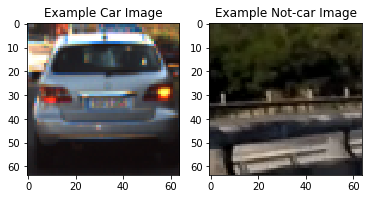

In [6]:
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

### Utilitys

In [7]:
import sys

# Print iterations progress
def print_progress(iteration, total):
    """
    Call in a loop to create terminal progress bar
    Parameters
    ----------
    iteration :
                Current iteration (Int)
    total     :
                Total iterations (Int)
    """
    str_format = "{0:.0f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(100 * iteration / float(total)))
    bar = '█' * filled_length + '-' * (100 - filled_length)

    sys.stdout.write('\r |%s| %s%%' % (bar, percents)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()
    
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

def plot_row4(img1, img2, img3, img4, label_1, label_2, label_3, label_4, graysc=True):
    # Plot the result (1 row with 4 images)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4))
    f.tight_layout()
    if graysc:
        ax1.imshow(img1, cmap='gray')
    else:
        ax1.imshow(img1)
    ax1.set_title(label_1, fontsize=14)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(label_2, fontsize=14)
    ax3.imshow(img3, cmap='gray')
    ax3.set_title(label_3, fontsize=14)
    ax4.imshow(img4, cmap='gray')
    ax4.set_title(label_4, fontsize=14)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
# Save data to pickle file
def saveTrainingDataIntoPickle(svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins):
    dist_pickle = {}
    dist_pickle["svc"] = svc
    dist_pickle["scaler"] = X_scaler
    dist_pickle["orient"] = orient
    dist_pickle["pix_per_cell"] = pix_per_cell
    dist_pickle["cell_per_block"] = cell_per_block
    dist_pickle["spatial_size"] = spatial_size
    dist_pickle["hist_bins"] = hist_bins
    pickle.dump(dist_pickle, open("svc_pickle.p", 'wb') )
    
    print('Classifier parameters were saved to file')
    

def loadTrainingDataFromPickle():
    dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    
    print('Loading is done')
    return svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins


## Functions for feature extraction

In [21]:
from skimage.feature import hog
# Define a function to return HOG features and visualization


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'YCrCb2RGB':
        return cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
            
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Define paarmeter for feature extraction and a better handling

In [ ]:
## Tweak these parameters
#color_space    = 'YCrCb'    # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient         = 9          # HOG orientations
#pix_per_cell   = 8          # HOG pixels per cell
#cell_per_block = 2          # HOG cells per block
#hog_channel    = 'ALL'      # Can be 0, 1, 2, or "ALL"
#spatial_size   = (32, 32)   # Spatial binning dimensions
#hist_bins      = 32         # Number of histogram bins
#spatial_feat   = True       # Spatial features on or off
#hist_feat      = True       # Histogram features on or off
#hog_feat       = True       # HOG features on or off

## Classifier training pipeline

In [9]:
import numpy as np
from sklearn.grid_search import GridSearchCV
from sklearn import datasets, svm
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

C:\Users\domin\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\domin\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [26]:
# Tweak these parameters
color_space    = 'YCrCb'    # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient         = 9          # HOG orientations
pix_per_cell   = 8          # HOG pixels per cell
cell_per_block = 2          # HOG cells per block
hog_channel    = 'ALL'      # Can be 0, 1, 2, or "ALL"
spatial_size   = (32, 32)   # Spatial binning dimensions
hist_bins      = 16         # Number of histogram bins
spatial_feat   = True       # Spatial features on or off
hist_feat      = True       # Histogram features on or off
hog_feat       = True       # HOG features on or off


# class CAR feature extraction
t=time.time()

car_features = extract_features(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to CARS feature extraction')
print('CARS feature extraction done')

# class NONCAR feature extraction
t=time.time()
notcar_features = extract_features(notcars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to NONCARS feature extraction')
print('NONCARS feature extraction done')



31.14076 Seconds to CARS feature extraction
CARS feature extraction done
30.97711 Seconds to NONCARS feature extraction
NONCARS feature extraction done


In [27]:
##### Normalize randomize, create feature vecto and split the data into train and test set ##########
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial_size,
    'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))

Using spatial binning of: (32, 32) and 16 histogram bins
Feature vector length: 8412


In [ ]:
# Cross validation with sklearn and GridSearchCV()
##################################
parameter_candidates = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
print('parameter setting done. Now before GridSearchCV(...)')
# Create a classifier object with the classifier and parameter candidates
svc = GridSearchCV(estimator=svm.SVC(), param_grid=parameter_candidates, n_jobs=-1)
print('GridSearchCV done. Now before fit()')
t=time.time()
# Train the classifier on data1's feature and target data
svc.fit(X_train, y_train)
print('svc.fit(X_train, y_train) Now before getting best parameters')

t2 = time.time()

# View the best parameters for the model found using grid search
print('Best C:',clf.best_estimator_.C)
print('Best Kernel:',clf.best_estimator_.kernel)
print('Best Gamma:',clf.best_estimator_.gamma)
##################################

In [28]:
##### Training of the classifier ##########
# Use a linear SVC 
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8412
38.12 Seconds to train SVC...
Test Accuracy of SVC =  0.991
My SVC predicts:  [ 0.  0.  1.  0.  0.  0.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  0.  1.  1.  0.]
0.03208 Seconds to predict 10 labels with SVC


In [29]:
saveTrainingDataIntoPickle(svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins)
print('Classifier parameters were saved to file')


Classifier parameters were saved to file
Classifier parameters were saved to file


## Pipeline

In [ ]:

    
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

## Multidetection and false positives

In [30]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [ ]:
svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins = loadTrainingDataFromPickle() 

In [31]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    ystart_ystop_scale = [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]
    win_pos = []
    # ADD MULTISCALING:
    for (ystart, ystop, scale) in ystart_ystop_scale:
        img_tosearch = img[ystart:ystop, :, :]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = ((ch1.shape[1] // pix_per_cell) - cell_per_block + 1)
        nyblocks = ((ch1.shape[0] // pix_per_cell) - cell_per_block + 1)
        nfeat_per_block = orient * cell_per_block**2
    
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 8*8
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    

        for xb in range(nxsteps + 1):
            for yb in range(nysteps + 1):
                ypos = yb * cells_per_step
                xpos = xb * cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos * pix_per_cell
                ytop = ypos * pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))
          
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)
            
                # If detected
                if test_prediction == 1:
                    xbox_left = np.int(xleft * scale)
                    ytop_draw = np.int(ytop * scale)
                    win_draw = np.int(window * scale)
                    cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart), 
                                  (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0,0,255), 2)
                    win_pos.append(((xbox_left, ytop_draw + ystart), 
                                    (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
    return draw_img, win_pos


In [32]:
from scipy.ndimage.measurements import label

def processDetection(img):
    
    out_img, win_pos = find_cars(img, svc, X_scaler, orient, pix_per_cell, 
                                 cell_per_block, spatial_size, hist_bins)
    # Read in image similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # AVG boxes
    last_hot_labels.put_labels(win_pos)
    win_pos = last_hot_labels.get_labels()
    
    # Add heat to each box in box list
    heat = add_heat(heat, win_pos)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 22)
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    #plot_row2(img, out_img, 'Source', 'All Detections')
    #plot_row2(draw_img, heatmap, 'Car Positions', 'Heat Map')
    return draw_img

In [33]:
# Accumulation of labels from last N frames
class LabelsQueue():
    def __init__ (self):
        # Number labels to store
        self.queue_len = 10 
        self.queue = []

    # Put new frame
    def put_labels(self, labels):
        if (len(self.queue) > self.queue_len):
            tmp = self.queue.pop(0)
        self.queue.append(labels)
    
    # Get last N frames hot boxes
    def get_labels(self):
        b = []
        for label in self.queue:
            b.extend(label)
        return b

In [34]:
class VehicleTracker:
    def __init__(self, frame_size):
        self.heatmap = np.zeros(frame_size)
        self.frames = []


    def process_frame(self, frame):
        print('I am inside process frame')
        # do your processing...
        out_img, win_pos = find_cars(frame, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins)
        print('I after find cars')
        
        self.heatmap = add_heat(self.heatmap, win_pos)
        print('I after add_heat(self.heatmap, win_pos)')

        # example using heatmap
        new_frame_factor = 0.3
        self.heatmap = new_frame_factor * frame + (1-new_frame_factor) * self.heatmap
        print('I after new_frame_factor * frame + (1-new_frame_factor) * self.heatmap')

    
        # do threshold and some kind of detection (blob or cv.contours)
        self.heatmap = apply_threshold(self.heatmap, 22)
        print('I after apply_threshold')

        self.heatmap = np.clip(self.heatmap, 0, 255)
        print('I after np.clip')

    
        labels = label(self.heatmap)
        print('I after label')

    
        # example using averaged frame
        if len(self.frames)< 5:
            nb_frames_avg = len(self.frames)
        else:
            nb_frames_avg = 5
        
        print('I after if conditions',len(self.frames),nb_frames_avg)

        
        self.frames.append(frame)
        print('I after frames.append')

        avg_frame = np.mean(np.array(self.frames)[-nb_frames_avg], axis=-1)
        print('I after np.mean')

    
        draw_img = draw_labeled_bboxes(out_img,labels)
        draw_img = convert_color(draw_img, conv='YCrCb2RGB')
    
    
        #draw_img = draw_labeled_bboxes(np.copy(frame), labels)
        plot_row2(frame, out_img, 'Source', 'All Detections')
        plot_row2(draw_img, self.heatmap, 'Car Positions', 'Heat Map')

        return draw_img




I am inside process frame
I after find cars
I after add_heat(self.heatmap, win_pos)
I after new_frame_factor * frame + (1-new_frame_factor) * self.heatmap
I after apply_threshold
I after np.clip
I after label
I after if conditions 0 0
I after frames.append
I after np.mean
[MoviePy] >>>> Building video project_video_submission_draft_1.mp4
[MoviePy] Writing video project_video_submission_draft_1.mp4


OSError: [WinError 6] The handle is invalid

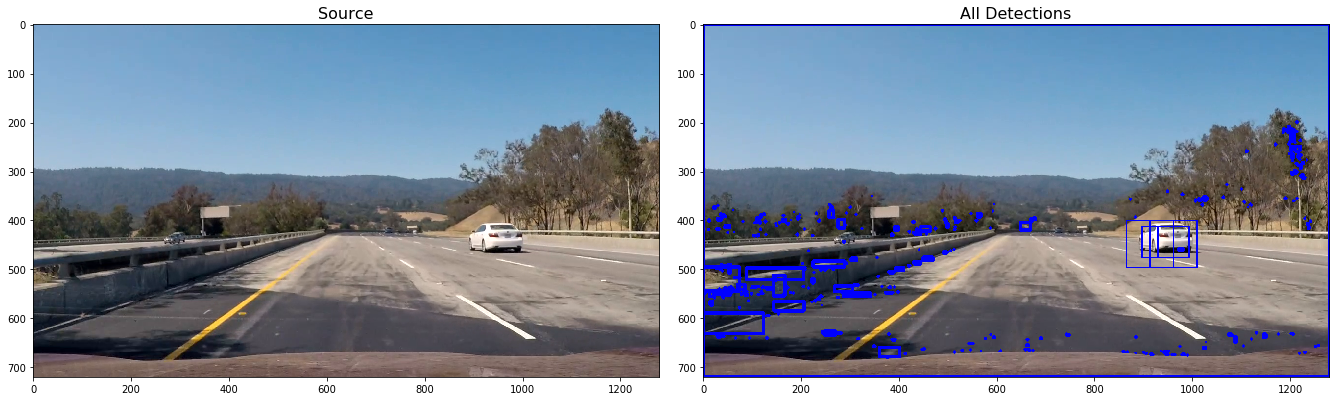

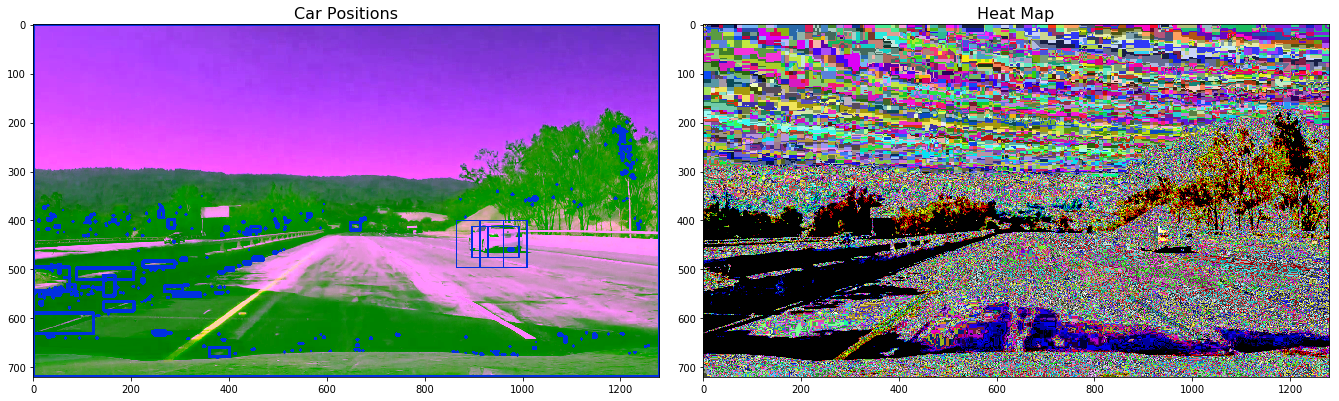

In [24]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_video = 'project_video_submission_draft_1.mp4'
vehicleTracker = VehicleTracker((720,1280,3))
clip1 = VideoFileClip("project_video.mp4").subclip(22,23)
#clip1 = VideoFileClip("project_video.mp4")#.subclip(0,3)

video_clip = clip1.fl_image(vehicleTracker.process_frame)
%time video_clip.write_videofile(output_video, audio=False)

In [36]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
last_hot_labels = LabelsQueue()
output_video = 'project_first_darft.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(22,40)
video_clip = clip1.fl_image(processDetection)
%time video_clip.write_videofile(output_video, audio=False)


[MoviePy] >>>> Building video project_first_darft.mp4
[MoviePy] Writing video project_first_darft.mp4


100%|█████████▉| 1260/1261 [12:40<00:00,  1.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_first_darft.mp4 

Wall time: 12min 41s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))